## Import modules

In [28]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from matplotlib import pyplot as plt
%matplotlib inline

import os
import re
import string
from time import time

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Preprocessing

In [5]:
def clean_doc(doc):
    # Lowercase
    doc = doc.lower()
    # Remove numbers
    doc = re.sub(r"[0-9]+", "", doc)
    # Split in tokens
    tokens = doc.split()
    # Remove punctuation
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    return ' '.join(tokens)

def read_files(path):
    """Read each doc given a specific path, clean them with the clean_doc function and returns a list of strings"""
    documents = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    clean = []
    tokenize  = lambda x: simple_preprocess(x)
    for d in documents:
        with open(f"{path}/{d}", encoding='utf-8') as f:
            doc = f.read()
            doc = clean_doc(doc)
            clean.append(tokenize(doc))
    return clean

In [6]:
# Directory with raw files
TEXT_DIR  = "/home/tdelatte/projects/notebooks/data/word_embeddings/" 

In [13]:
%%time
# Load and clean data
docs = read_files(TEXT_DIR)

print(f"Number of documents: {len(docs)}") 

Number of documents: 7
CPU times: user 7.49 s, sys: 89.7 ms, total: 7.58 s
Wall time: 7.61 s


In [32]:
# Download Google word embeddings
!wget -P projects/notebooks/data/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-06-17 15:53:20--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.137.62
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.137.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘projects/notebooks/data/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G   671KB/s    in 36m 15s 

2020-06-17 16:29:36 (739 KB/s) - ‘projects/notebooks/data/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [14]:
%%time
EMBEDDING_FILE = '/home/tdelatte/projects/notebooks/data/GoogleNews-vectors-negative300.bin.gz' 
# Vectors instantiated as KeyedVectors
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

CPU times: user 5min 20s, sys: 41.7 s, total: 6min 2s
Wall time: 6min 10s


In [15]:
%%time
# Build Word2Vec model 
google_model = Word2Vec(size = 300, window=5, min_count = 20, workers = -1)
google_model.build_vocab(docs)

# Merge Google's model weight matrix and intersect with the current vocabulary.
google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

#Train the model
google_model.train(docs, total_examples=google_model.corpus_count, epochs = 5)

CPU times: user 3min 51s, sys: 3.52 s, total: 3min 54s
Wall time: 3min 55s
Parser   : 496 ms


(0, 0)

In [16]:
# Find words with most similar vectors of "Harry"
google_model.wv.most_similar(positive=["harry"])

[('neville', 0.5812051296234131),
 ('mr', 0.5559774041175842),
 ('dennis', 0.5308670997619629),
 ('james', 0.5300297737121582),
 ('davies', 0.5283474922180176),
 ('arry', 0.520870566368103),
 ('johnson', 0.5157880783081055),
 ('roberts', 0.4989515244960785),
 ('dont', 0.49838465452194214),
 ('charlie', 0.49837130308151245)]

In [18]:
google_model.wv.most_similar(positive=["basilisk"])

[('dementors', 0.6436929702758789),
 ('hippogriff', 0.5677863955497742),
 ('dementor', 0.5650946497917175),
 ('creature', 0.5508249998092651),
 ('gargoyle', 0.5491913557052612),
 ('spider', 0.5463742017745972),
 ('serpent', 0.5414613485336304),
 ('goblin', 0.5300490260124207),
 ('horcrux', 0.5296100378036499),
 ('spiders', 0.5049328804016113)]

In [19]:
google_model.wv.most_similar(positive=["wand"])

[('wands', 0.7150397300720215),
 ('broom', 0.531521201133728),
 ('broomstick', 0.46065953373908997),
 ('dementors', 0.4059273600578308),
 ('hippogriff', 0.38803809881210327),
 ('basilisk', 0.3835200071334839),
 ('enchantments', 0.38186854124069214),
 ('sword', 0.38140869140625),
 ('dementor', 0.3698751926422119),
 ('gently', 0.3696576654911041)]

In [20]:
# Check similarity between words
sim = google_model.wv.similarity("harry", "ron")
print(f"Similarity between 'harry' and 'ron' is {format(sim)}")

Similarity between 'harry' and 'ron' is 0.47980862855911255


In [21]:
odd = google_model.doesnt_match(["harry", "ron", "hermione", "library"])
print(f"word that does not belong in the given list is : {odd}")

word that does not belong in the given list is : library


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.
/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [22]:
print(google_model.most_similar_cosmul(positive=["woman", "king"], negative=["man"], topn=5))

[('prince', 0.800979733467102), ('knight', 0.6788281202316284), ('mistress', 0.6786445379257202), ('witch', 0.6756536364555359), ('doge', 0.6740080118179321)]


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


In [1]:
# Check difference with another method
print(google_model.most_similar(positive=["woman", "king"], negative=["man"], topn=5))

NameError: name 'google_model' is not defined

In [23]:
print(google_model.most_similar_cosmul(positive=["gryffindor", "malfoy"], negative=["potter"], topn=5))

[('lovegood', 0.6707919239997864), ('night', 0.6478657722473145), ('lucius', 0.6330291032791138), ('slytherins', 0.6146992444992065), ('powers', 0.6112741827964783)]


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


## T-SNE Visualization

In [29]:
def tsne_plot(model):
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=25000, random_state=32)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords="offset points",
                     ha="right",
                     va="bottom")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


/home/tdelatte/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


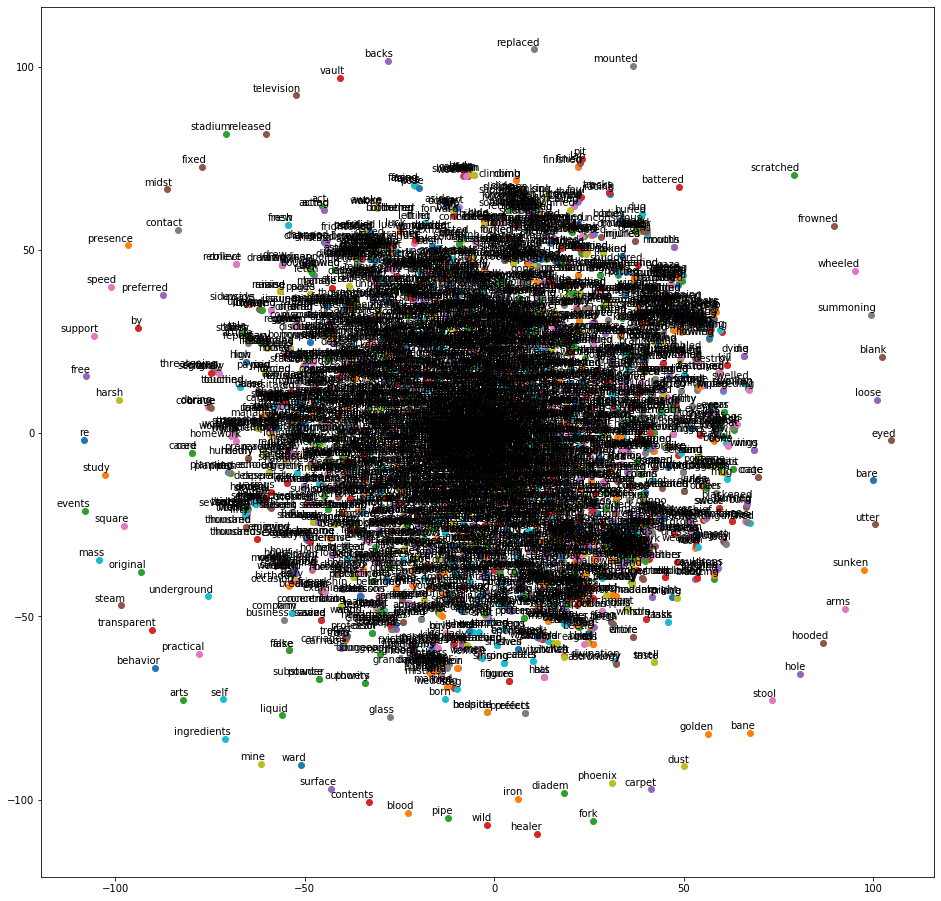

In [30]:
%%time
tsne_plot(google_model)